<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/10/PTE_DL10_CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

keras = tf.keras

In [ ]:
temp = pd.read_csv(
    "temp.csv", sep=';'
    ).values

series = temp

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("idő")
    plt.ylabel("hőmérséklet")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

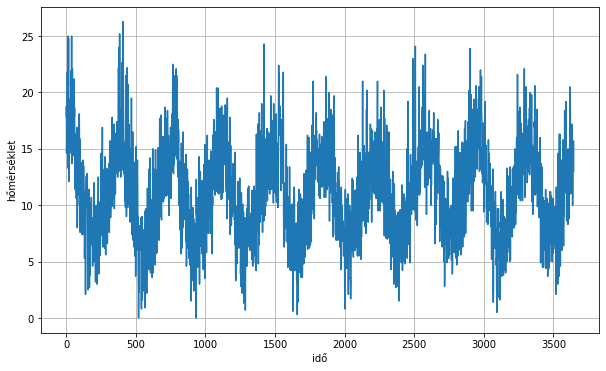

In [ ]:
time = np.arange(len(series))
#time = temp[:,0].astype(np.float32)
series = temp[:,0].astype(np.float32)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
13/13 [==============================] - 15s 134ms/step - loss: 66.9115 - mae: 67.4115 - lr: 1.0000e-08
Epoch 2/100
13/13 [==============================] - 2s 129ms/step - loss: 65.9967 - mae: 66.4967 - lr: 1.1220e-08
Epoch 3/100
13/13 [==============================] - 2s 127ms/step - loss: 64.6425 - mae: 65.1425 - lr: 1.2589e-08
Epoch 4/100
13/13 [==============================] - 2s 128ms/step - loss: 62.9406 - mae: 63.4406 - lr: 1.4125e-08
Epoch 5/100
13/13 [==============================] - 2s 127ms/step - loss: 60.7698 - mae: 61.2698 - lr: 1.5849e-08
Epoch 6/100
13/13 [==============================] - 2s 127ms/step - loss: 57.9370 - mae: 58.4370 - lr: 1.7783e-08
Epoch 7/100
13/13 [==============================] - 2s 128ms/step - loss: 54.8731 - mae: 55.3731 - lr: 1.9953e-08
Epoch 8/100
13/13 [==============================] - 2s 128ms/step - loss: 52.2487 - mae: 52.7487 - lr: 2.2387e-08
Epoch 9/100
13/13 [==============================] - 2s 126ms/step - loss: 49.8

(1e-08, 0.0001, 0.0, 30.0)

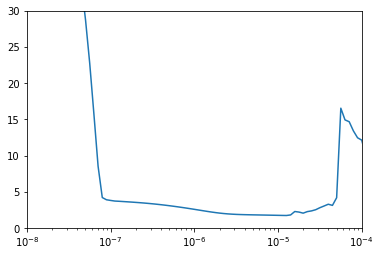

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
13/13 [==============================] - 8s 313ms/step - loss: 22.7555 - mae: 23.2514 - val_loss: 14.8210 - val_mae: 15.3207
Epoch 2/500
13/13 [==============================] - 3s 212ms/step - loss: 7.8522 - mae: 8.3420 - val_loss: 5.7110 - val_mae: 6.1974
Epoch 3/500
13/13 [==============================] - 3s 209ms/step - loss: 4.0845 - mae: 4.5620 - val_loss: 3.8136 - val_mae: 4.2869
Epoch 4/500
13/13 [==============================] - 3s 208ms/step - loss: 2.9850 - mae: 3.4529 - val_loss: 2.6483 - val_mae: 3.1146
Epoch 5/500
13/13 [==============================] - 3s 210ms/step - loss: 2.4737 - mae: 2.9353 - val_loss: 2.2170 - val_mae: 2.6760
Epoch 6/500
13/13 [==============================] - 3s 212ms/step - loss: 2.2264 - mae: 2.6842 - val_loss: 2.0267 - val_mae: 2.4835
Epoch 7/500
13/13 [==============================] - 3s 213ms/step - loss: 2.0721 - mae: 2.5283 - val_loss: 1.9049 - val_mae: 2.3600
Epoch 8/500
13/13 [==============================] - 3s 211ms/ste

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

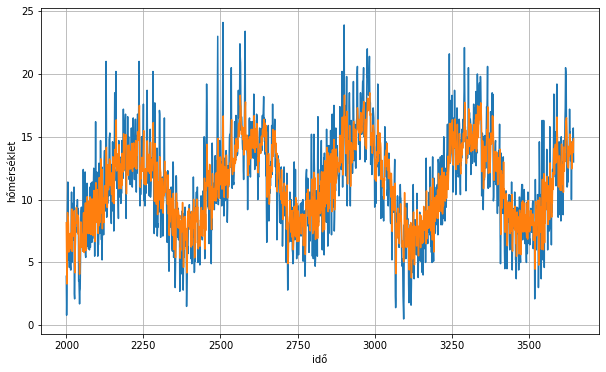

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8458197

## Fully Convolutional Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
13/13 [==============================] - 5s 155ms/step - loss: 10.3859 - mae: 10.8848 - lr: 1.0000e-04
Epoch 2/100
13/13 [==============================] - 1s 46ms/step - loss: 10.1384 - mae: 10.6371 - lr: 1.0798e-04
Epoch 3/100
13/13 [==============================] - 1s 45ms/step - loss: 9.8100 - mae: 10.3086 - lr: 1.1659e-04
Epoch 4/100
13/13 [==============================] - 1s 47ms/step - loss: 9.2937 - mae: 9.7920 - lr: 1.2589e-04
Epoch 5/100
13/13 [==============================] - 1s 45ms/step - loss: 8.4098 - mae: 8.9072 - lr: 1.3594e-04
Epoch 6/100
13/13 [==============================] - 1s 46ms/step - loss: 6.8250 - mae: 7.3193 - lr: 1.4678e-04
Epoch 7/100
13/13 [==============================] - 1s 45ms/step - loss: 4.2522 - mae: 4.7316 - lr: 1.5849e-04
Epoch 8/100
13/13 [==============================] - 1s 44ms/step - loss: 3.1078 - mae: 3.5734 - lr: 1.7113e-04
Epoch 9/100
13/13 [==============================] - 1s 46ms/step - loss: 2.8733 - mae: 3.3373 - l

(0.0001, 0.1, 0.0, 30.0)

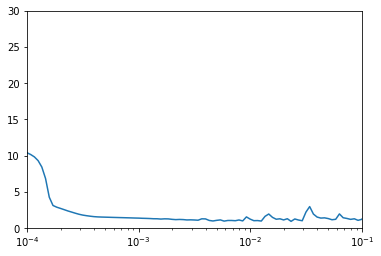

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
13/13 [==============================] - 4s 137ms/step - loss: 9.7882 - mae: 10.2868 - val_loss: 9.9997 - val_mae: 10.4993
Epoch 2/500
13/13 [==============================] - 2s 102ms/step - loss: 9.3320 - mae: 9.8303 - val_loss: 9.4422 - val_mae: 9.9413
Epoch 3/500
13/13 [==============================] - 2s 101ms/step - loss: 8.7310 - mae: 9.2290 - val_loss: 8.7075 - val_mae: 9.2058
Epoch 4/500
13/13 [==============================] - 2s 101ms/step - loss: 7.9319 - mae: 8.4288 - val_loss: 7.7236 - val_mae: 8.2218
Epoch 5/500
13/13 [==============================] - 2s 104ms/step - loss: 6.8634 - mae: 7.3590 - val_loss: 6.4020 - val_mae: 6.8983
Epoch 6/500
13/13 [==============================] - 2s 104ms/step - loss: 5.4727 - mae: 5.9624 - val_loss: 4.6887 - val_mae: 5.1735
Epoch 7/500
13/13 [==============================] - 2s 106ms/step - loss: 3.8690 - mae: 4.3463 - val_loss: 2.9922 - val_mae: 3.4602
Epoch 8/500
13/13 [==============================] - 2s 160ms/step 

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

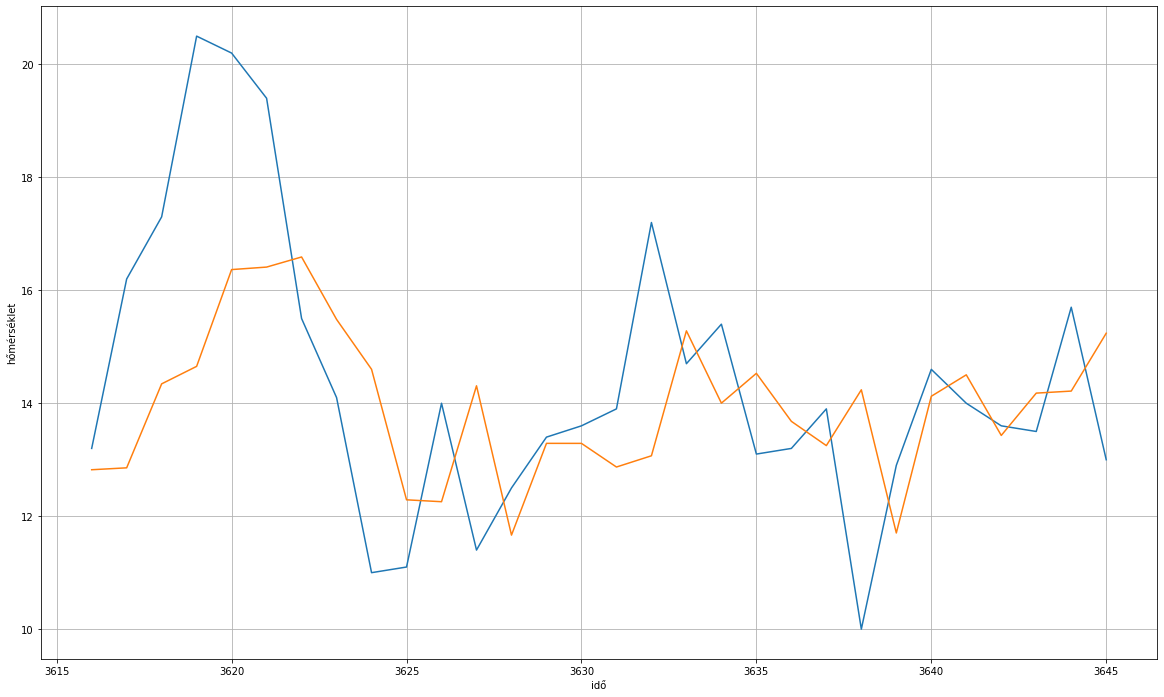

In [ ]:
plt.figure(figsize=(20, 12))
plot_series(time_valid[-30:], x_valid[-30:])
plot_series(time_valid[-30:], cnn_forecast[-30:])

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

1.8596818